# Steps for association analysis between risk factors and cardiovascular age-delta

In [1]:
library(tidyverse)
library(lme4)
library(emmeans)
library(ISwR)
library(ggridges)
library(MatchIt)
library(dplyr)
library(jtools)
library(broom)
library(forestmangr)

Warning message:
“Failed to locate timezone database”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.8     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack




# Introduction

This .rmd uses outputs generated by the first stage of the method. This first stage generates a predicted age that is corrected for 'regression to the mean' bias associated in predicting biological age from chronological age.  

Inputs are healthy validation set predicted ages and remaining approx. 34K subjects' predicted ages in the UK Biobank.

In [2]:
#Load non-healthy outputs: 
non.healthy.df <- read_csv("../data/synthetic_db_with_risk_factors_and_deltas.csv")
#non.healthy.df <- non.healthy.df %>% select("eid_40616", "age_at_MRI", "sex", "ca_delta")

Rows: 34137 Columns: 132
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (132): LVEDV, LVESV, LVSV, LVEF, LVCO, LVM, rad_2, rad_3, rad_4, rad_5, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# Disease 1: Diabetes 

## (i) propensity match samples

Healthy sample is matched to disease sample by age and sex.

First, examine if there are any differences in covariates:

In [3]:
#combine disease of interest with predictions.
diabetespredictions <- read_csv("../data/synthetic_db_with_risk_factors_and_deltas.csv")

Rows: 34137 Columns: 132
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (132): LVEDV, LVESV, LVSV, LVEF, LVCO, LVM, rad_2, rad_3, rad_4, rad_5, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
non.healthy.df$diabetes <- as.factor(non.healthy.df$rf_diabetes)

with(diabetespredictions, t.test(age_at_MRI ~ rf_diabetes))  #(repeat for each covariate)
with(diabetespredictions, t.test(sex ~ rf_diabetes))  #(repeat for each covariate)


	Welch Two Sample t-test

data:  age_at_MRI by rf_diabetes
t = -7.2518, df = 4634.4, p-value = 4.795e-13
alternative hypothesis: true difference in means between group 0 and group 1 is not equal to 0
95 percent confidence interval:
 -1.1962527 -0.6871013
sample estimates:
mean in group 0 mean in group 1 
       63.90242        64.84410 



	Welch Two Sample t-test

data:  sex by rf_diabetes
t = -7.1905, df = 4605.6, p-value = 7.497e-13
alternative hypothesis: true difference in means between group 0 and group 1 is not equal to 0
95 percent confidence interval:
 -0.07960591 -0.04549683
sample estimates:
mean in group 0 mean in group 1 
      0.4874623       0.5500136 


In [5]:
m_ps <- glm(rf_diabetes ~ age_at_MRI + sex, 
            family = binomial(), data = non.healthy.df)
summary(m_ps)

prs_df <- data.frame(pr_score = predict(m_ps, type = "response"),
                     disease = m_ps$model$rf_diabetes)
# head(prs_df)


Call:
glm(formula = rf_diabetes ~ age_at_MRI + sex, family = binomial(), 
    data = non.healthy.df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.5715  -0.4980  -0.4661  -0.4357   2.2938  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -3.240648   0.152087 -21.308  < 2e-16 ***
age_at_MRI   0.015563   0.002334   6.668 2.60e-11 ***
sex          0.235275   0.035206   6.683 2.34e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 23296  on 34136  degrees of freedom
Residual deviance: 23200  on 34134  degrees of freedom
AIC: 23206

Number of Fisher Scoring iterations: 5


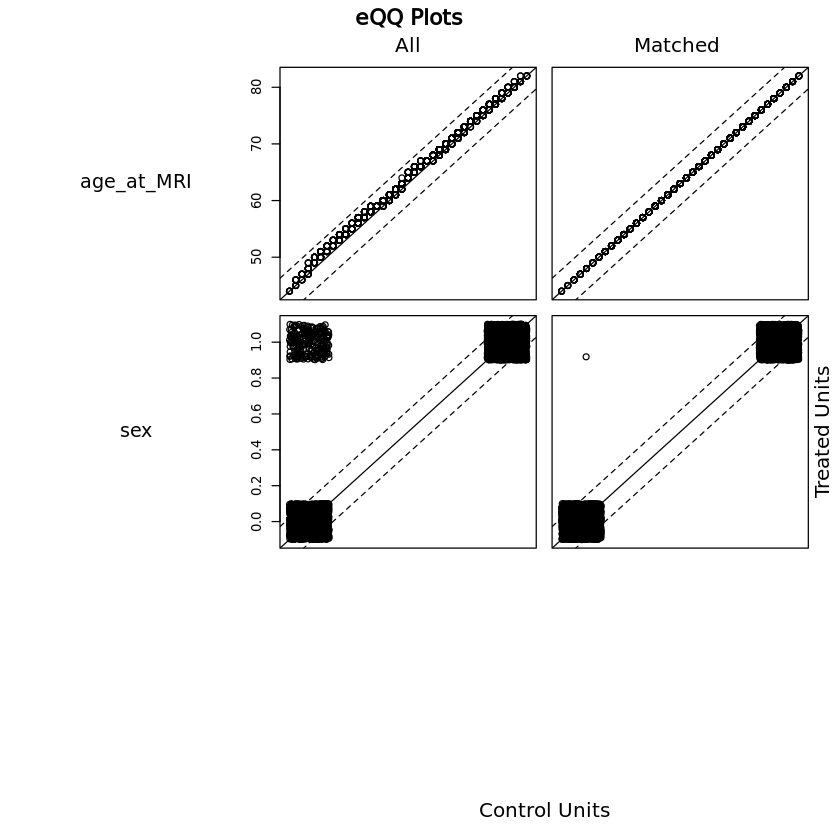

In [6]:
#matching process
mod_match <- matchit(rf_diabetes ~ age_at_MRI + sex,
                     method = "nearest", data = non.healthy.df)
#summary(mod_match)
plot(mod_match)

Dimensions of matched data (equal numbers in both groups once matched, number represents total of healthy + disease):

In [7]:
dta_m <- match.data(mod_match)
dim(dta_m)

[1] 7338  136

Now compare distributions of matched data:

In [8]:
dta_m %>%
  group_by(rf_diabetes) %>%
  select(one_of(c('rf_diabetes', 'sex'))) %>%
  summarise_all(funs(mean))

Warning message:
“`funs()` was deprecated in dplyr 0.8.0.
Please use a list of either functions or lambdas: 

  # Simple named list: 
  list(mean = mean, median = median)

  # Auto named with `tibble::lst()`: 
  tibble::lst(mean, median)

  # Using lambdas
  list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was generated.”


rf_diabetes,sex
<dbl>,<dbl>
0,0.5500136
1,0.5500136


## (ii) analysis

In [9]:
summarydta_m <- dta_m %>% group_by(rf_diabetes) %>% 
	summarise(meanca_delta = mean(ca_delta), n= n()) 

summarydta_m$meanca_delta <- as.numeric(summarydta_m$meanca_delta)
summarydta_m$meanca_delta <- sprintf("%.3f",summarydta_m$meanca_delta)

### Summary:

In [10]:
summarydta_m

rf_diabetes,meanca_delta,n
<dbl>,<chr>,<int>
0,-0.135,3669
1,0.174,3669


### Plot:

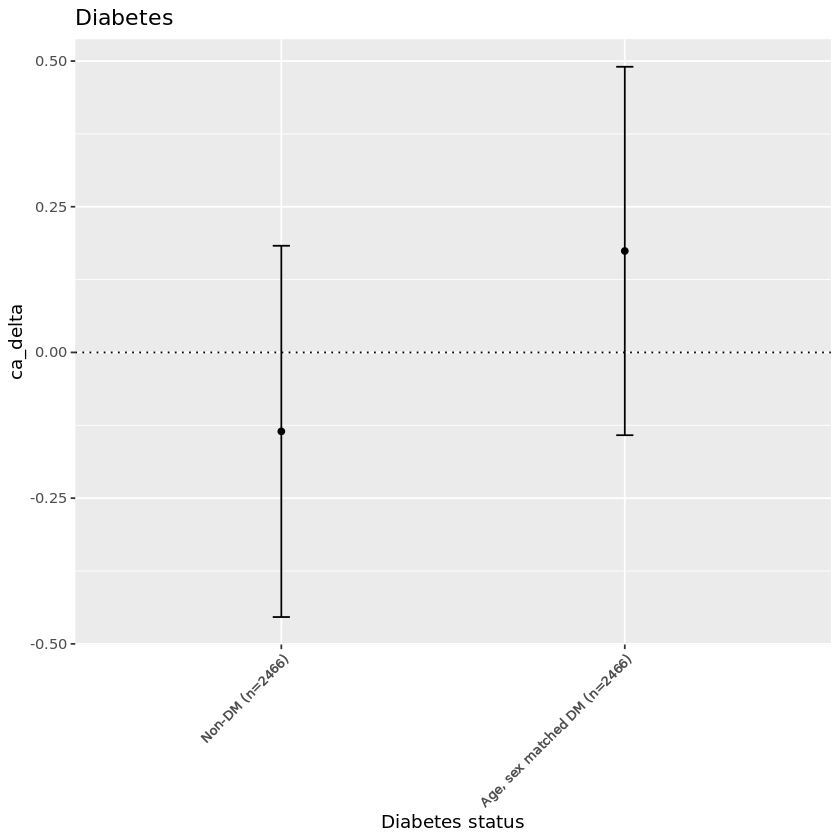

In [11]:
df_DM_plot <- ggplot(dta_m, aes(x=factor(rf_diabetes), y=ca_delta)) + 
  geom_point(stat="summary", fun = mean) + 
  geom_errorbar(stat="summary", width=0.05, fun.data="mean_se", fun.args = list(mult = 1.96)) +
  geom_hline(yintercept = 0, linetype='dotted') +
  theme(axis.text.x = element_text(face="bold", size=8, angle=45, hjust=1)) +
  ggtitle("Diabetes") +
  xlab("Diabetes status") +
  scale_x_discrete(labels=c("0" = "Non-DM (n=2466)", "1" =  "Age, sex matched DM (n=2466)"))
df_DM_plot

### Regression (adjusted for age, age^2, sex):

In [12]:
fitdm <- lm(ca_delta ~ rf_diabetes + poly(age_at_MRI, 2) + sex , dta_m)
summary(fitdm)
confint(fitdm, level = .95)

#female
fitdm_female <- lm(ca_delta ~  poly(age_at_MRI, 2) + sex*rf_diabetes , dta_m) #coefficient of diabetes = female coefficient. 
summary(fitdm_female)
confint(fitdm_female, level = .95)

#male
fitdm_male <- lm(ca_delta ~  poly(age_at_MRI, 2) + I(1-sex)*rf_diabetes , dta_m) #coefficient of diabetes = male coefficient. 
summary(fitdm_male)
confint(fitdm_male, level = .95)


Call:
lm(formula = ca_delta ~ rf_diabetes + poly(age_at_MRI, 2) + sex, 
    data = dta_m)

Residuals:
    Min      1Q  Median      3Q     Max 
-33.248  -6.850  -0.218   6.791  34.131 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)  
(Intercept)            0.1550     0.2055   0.754   0.4507  
rf_diabetes            0.3096     0.2289   1.353   0.1762  
poly(age_at_MRI, 2)1  -4.3951     9.8172  -0.448   0.6544  
poly(age_at_MRI, 2)2  11.8102     9.8023   1.205   0.2283  
sex                   -0.5282     0.2304  -2.293   0.0219 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 9.802 on 7333 degrees of freedom
Multiple R-squared:  0.001205,	Adjusted R-squared:  0.0006602 
F-statistic: 2.212 on 4 and 7333 DF,  p-value: 0.06514


,2.5 %,97.5 %
(Intercept),-0.2478601,0.55792884
rf_diabetes,-0.1390727,0.75818057
"poly(age_at_MRI, 2)1",-23.6397501,14.84949413
"poly(age_at_MRI, 2)2",-7.4051133,31.02549636
sex,-0.9797560,-0.07659024



Call:
lm(formula = ca_delta ~ poly(age_at_MRI, 2) + sex * rf_diabetes, 
    data = dta_m)

Residuals:
    Min      1Q  Median      3Q     Max 
-33.316  -6.844  -0.200   6.812  34.063 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)
(Intercept)           0.08751    0.24135   0.363    0.717
poly(age_at_MRI, 2)1 -4.39513    9.81772  -0.448    0.654
poly(age_at_MRI, 2)2 11.81019    9.80277   1.205    0.228
sex                  -0.40541    0.32555  -1.245    0.213
rf_diabetes           0.44460    0.34118   1.303    0.193
sex:rf_diabetes      -0.24553    0.46004  -0.534    0.594

Residual standard error: 9.803 on 7332 degrees of freedom
Multiple R-squared:  0.001244,	Adjusted R-squared:  0.0005628 
F-statistic: 1.826 on 5 and 7332 DF,  p-value: 0.1041


,2.5 %,97.5 %
(Intercept),-0.3856115,0.5606381
"poly(age_at_MRI, 2)1",-23.6406891,14.8504331
"poly(age_at_MRI, 2)2",-7.4060508,31.0264339
sex,-1.0435851,0.2327641
rf_diabetes,-0.2242198,1.1134120
sex:rf_diabetes,-1.1473452,0.6562948



Call:
lm(formula = ca_delta ~ poly(age_at_MRI, 2) + I(1 - sex) * rf_diabetes, 
    data = dta_m)

Residuals:
    Min      1Q  Median      3Q     Max 
-33.316  -6.844  -0.200   6.812  34.063 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)
(Intercept)             -0.3179     0.2183  -1.456    0.145
poly(age_at_MRI, 2)1    -4.3951     9.8177  -0.448    0.654
poly(age_at_MRI, 2)2    11.8102     9.8028   1.205    0.228
I(1 - sex)               0.4054     0.3256   1.245    0.213
rf_diabetes              0.1991     0.3086   0.645    0.519
I(1 - sex):rf_diabetes   0.2455     0.4600   0.534    0.594

Residual standard error: 9.803 on 7332 degrees of freedom
Multiple R-squared:  0.001244,	Adjusted R-squared:  0.0005628 
F-statistic: 1.826 on 5 and 7332 DF,  p-value: 0.1041


,2.5 %,97.5 %
(Intercept),-0.7458100,0.1100155
"poly(age_at_MRI, 2)1",-23.6406891,14.8504331
"poly(age_at_MRI, 2)2",-7.4060508,31.0264339
I(1 - sex),-0.2327641,1.0435851
rf_diabetes,-0.4058792,0.8040210
I(1 - sex):rf_diabetes,-0.6562948,1.1473452


# Disease 2: Hypertension 

## (i) propensity match samples

Healthy sample is matched to disease sample by age and sex.

First, examine if there are any differences in covariates.

In [13]:
non.healthy.df$htn <- as.factor(non.healthy.df$rf_htn)

with(non.healthy.df, t.test(age_at_MRI ~ rf_htn))  #(repeat for each covariate)
with(non.healthy.df, t.test(sex ~ rf_htn))  #(repeat for each covariate)


	Welch Two Sample t-test

data:  age_at_MRI by rf_htn
t = -27.257, df = 32186, p-value < 2.2e-16
alternative hypothesis: true difference in means between group 0 and group 1 is not equal to 0
95 percent confidence interval:
 -2.376973 -2.058054
sample estimates:
mean in group 0 mean in group 1 
       63.03944        65.25696 



	Welch Two Sample t-test

data:  sex by rf_htn
t = -13.35, df = 31921, p-value < 2.2e-16
alternative hypothesis: true difference in means between group 0 and group 1 is not equal to 0
95 percent confidence interval:
 -0.08336211 -0.06201811
sample estimates:
mean in group 0 mean in group 1 
      0.4625790       0.5352692 


In [14]:
m_ps_htn <- glm(rf_htn ~ age_at_MRI + sex, 
            family = binomial(), data = non.healthy.df)
summary(m_ps_htn)

prs_df_htn <- data.frame(pr_score = predict(m_ps_htn, type = "response"),
                     htn = m_ps_htn$model$rf_htn)
# head(prs_df)


Call:
glm(formula = rf_htn ~ age_at_MRI + sex, family = binomial(), 
    data = non.healthy.df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.4213  -1.0712  -0.8957   1.2370   1.6974  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -2.872508   0.096752  -29.69   <2e-16 ***
age_at_MRI   0.038686   0.001493   25.91   <2e-16 ***
sex          0.257540   0.022142   11.63   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 46742  on 34136  degrees of freedom
Residual deviance: 45875  on 34134  degrees of freedom
AIC: 45881

Number of Fisher Scoring iterations: 4


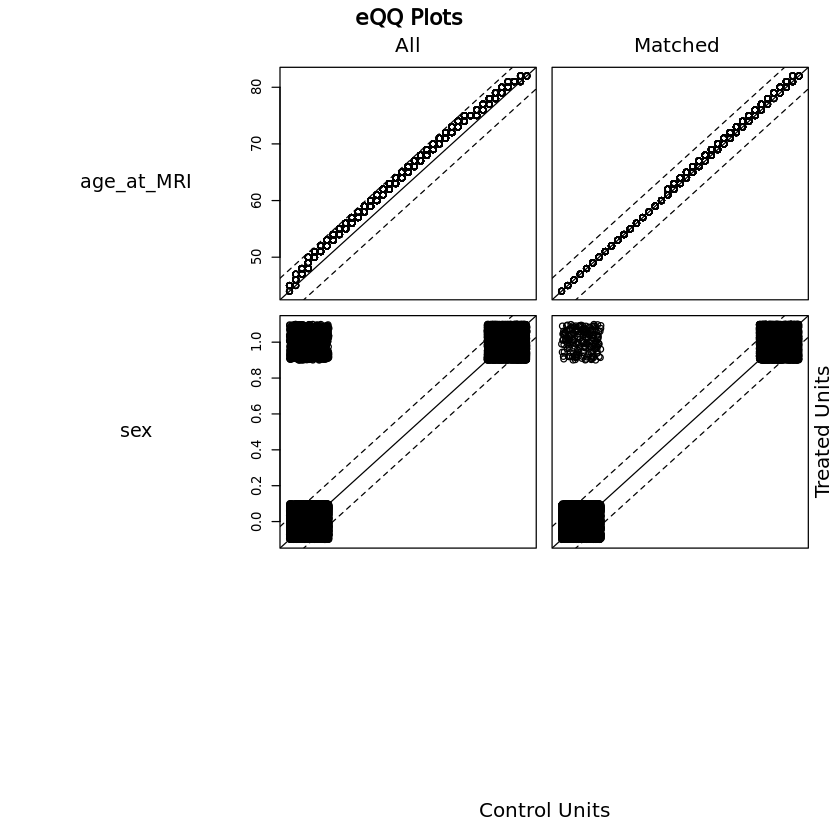

In [15]:
#matching process
mod_match_htn <- matchit(rf_htn ~ age_at_MRI + sex,
                     method = "nearest", data = non.healthy.df)
#summary(mod_match_htn)
plot(mod_match_htn)

Dimensions of matched data (equal numbers in both groups once matched, number represents total of healthy + htn)

In [16]:
dta_m_htn <- match.data(mod_match_htn)
dim(dta_m_htn)

[1] 29686   137

Now compare distributions of matched data

In [17]:
dta_m_htn %>%
  group_by(rf_htn) %>%
  select(one_of(c('rf_htn', 'sex'))) %>%
  summarise_all(funs(mean))

rf_htn,sex
<dbl>,<dbl>
0,0.5226706
1,0.5352692


## (ii) analysis

In [18]:
summarydta_m_htn <- dta_m_htn %>% group_by(rf_htn) %>% 
	summarise(mean_ca_delta = mean(ca_delta), n= n()) 

summarydta_m_htn$mean_ca_delta <- as.numeric(summarydta_m_htn$mean_ca_delta)
summarydta_m_htn$mean_ca_delta <- sprintf("%.3f",summarydta_m_htn$mean_ca_delta)

### Summary:

In [19]:
summarydta_m_htn

rf_htn,mean_ca_delta,n
<dbl>,<chr>,<int>
0,-0.748,14843
1,0.821,14843


### Plot:

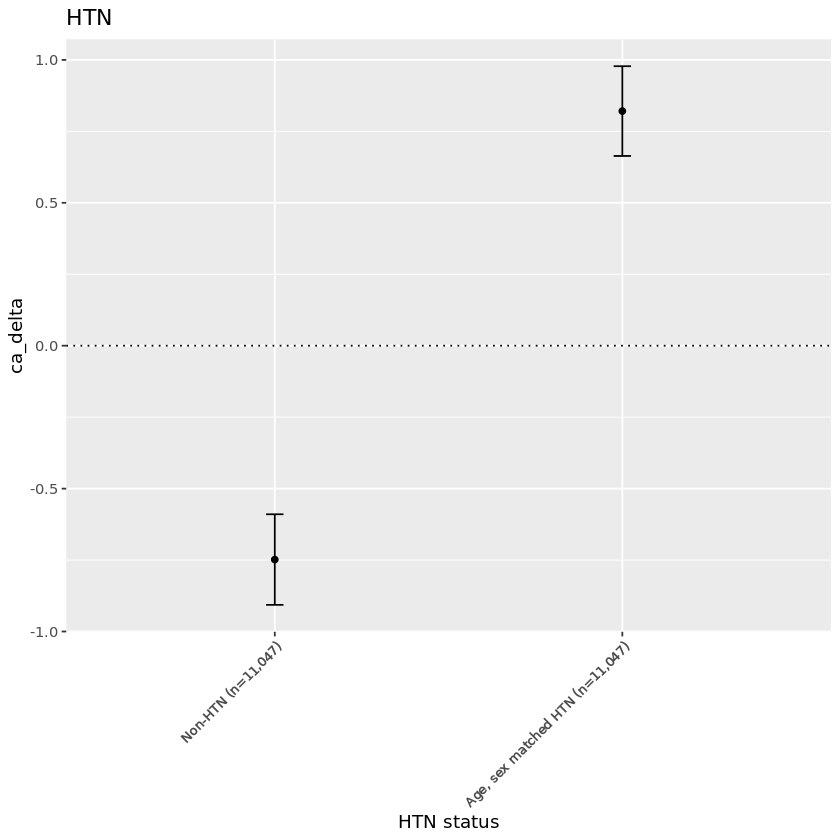

In [20]:
df_htn_plot <- ggplot(dta_m_htn, aes(x=factor(rf_htn), y=ca_delta)) + 
  geom_point(stat="summary", fun = mean) + 
  geom_errorbar(stat="summary", width=0.05, fun.data="mean_se", fun.args = list(mult = 1.96)) +
  geom_hline(yintercept = 0, linetype='dotted') +
  theme(axis.text.x = element_text(face="bold", size=8, angle=45, hjust=1)) +
  ggtitle("HTN") +
  xlab("HTN status") +
  scale_x_discrete(labels=c("0" = "Non-HTN (n=11,047)", "1" =  "Age, sex matched HTN (n=11,047)"))
df_htn_plot

### Regression (adjusted for age, age^2, sex):

In [21]:
fithtn <- lm(ca_delta ~ rf_htn + age_at_MRI+ poly(age_at_MRI, 2) + sex  , dta_m_htn)
summary(fithtn)
confint(fithtn, level = .95)

#female
fithtn_female <- lm(ca_delta ~  poly(age_at_MRI, 2) + sex*rf_htn , dta_m_htn) #coefficient of diabetes = female coefficient. 
summary(fithtn_female)
confint(fithtn_female, level = .95)

#male
fithtn_male <- lm(ca_delta ~  poly(age_at_MRI, 2) + I(1-sex)*rf_htn , dta_m_htn) #coefficient of diabetes = male coefficient. 
summary(fithtn_female)
confint(fithtn_female, level = .95)


Call:
lm(formula = ca_delta ~ rf_htn + age_at_MRI + poly(age_at_MRI, 
    2) + sex, data = dta_m_htn)

Residuals:
    Min      1Q  Median      3Q     Max 
-36.609  -6.815  -0.133   6.809  34.599 

Coefficients: (1 not defined because of singularities)
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)           0.074600   0.517591   0.144    0.885    
rf_htn                1.571240   0.113906  13.794  < 2e-16 ***
age_at_MRI           -0.007320   0.007857  -0.932    0.352    
poly(age_at_MRI, 2)1        NA         NA      NA       NA    
poly(age_at_MRI, 2)2 22.142638   9.809253   2.257    0.024 *  
sex                  -0.657250   0.114046  -5.763 8.34e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 9.802 on 29681 degrees of freedom
Multiple R-squared:  0.007692,	Adjusted R-squared:  0.007559 
F-statistic: 57.52 on 4 and 29681 DF,  p-value: < 2.2e-16


,2.5 %,97.5 %
(Intercept),-0.93990066,1.089100481
rf_htn,1.34797958,1.794500451
age_at_MRI,-0.02272063,0.008080425
"poly(age_at_MRI, 2)1",NA,NA
"poly(age_at_MRI, 2)2",2.91607216,41.369203679
sex,-0.88078623,-0.433714697



Call:
lm(formula = ca_delta ~ poly(age_at_MRI, 2) + sex * rf_htn, data = dta_m_htn)

Residuals:
    Min      1Q  Median      3Q     Max 
-36.587  -6.825  -0.133   6.808  34.579 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)          -0.42371    0.11647  -3.638 0.000275 ***
poly(age_at_MRI, 2)1 -9.03378    9.81466  -0.920 0.357352    
poly(age_at_MRI, 2)2 22.21658    9.81141   2.264 0.023559 *  
sex                  -0.61495    0.16113  -3.817 0.000136 ***
rf_htn                1.61602    0.16581   9.746  < 2e-16 ***
sex:rf_htn           -0.08477    0.22811  -0.372 0.710169    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 9.802 on 29680 degrees of freedom
Multiple R-squared:  0.007697,	Adjusted R-squared:  0.00753 
F-statistic: 46.04 on 5 and 29680 DF,  p-value: < 2.2e-16


,2.5 %,97.5 %
(Intercept),-0.6519931,-0.1954327
"poly(age_at_MRI, 2)1",-28.2709396,10.2033823
"poly(age_at_MRI, 2)2",2.9857783,41.4473769
sex,-0.9307677,-0.2991345
rf_htn,1.2910183,1.9410220
sex:rf_htn,-0.5318870,0.3623382



Call:
lm(formula = ca_delta ~ poly(age_at_MRI, 2) + sex * rf_htn, data = dta_m_htn)

Residuals:
    Min      1Q  Median      3Q     Max 
-36.587  -6.825  -0.133   6.808  34.579 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)          -0.42371    0.11647  -3.638 0.000275 ***
poly(age_at_MRI, 2)1 -9.03378    9.81466  -0.920 0.357352    
poly(age_at_MRI, 2)2 22.21658    9.81141   2.264 0.023559 *  
sex                  -0.61495    0.16113  -3.817 0.000136 ***
rf_htn                1.61602    0.16581   9.746  < 2e-16 ***
sex:rf_htn           -0.08477    0.22811  -0.372 0.710169    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 9.802 on 29680 degrees of freedom
Multiple R-squared:  0.007697,	Adjusted R-squared:  0.00753 
F-statistic: 46.04 on 5 and 29680 DF,  p-value: < 2.2e-16


,2.5 %,97.5 %
(Intercept),-0.6519931,-0.1954327
"poly(age_at_MRI, 2)1",-28.2709396,10.2033823
"poly(age_at_MRI, 2)2",2.9857783,41.4473769
sex,-0.9307677,-0.2991345
rf_htn,1.2910183,1.9410220
sex:rf_htn,-0.5318870,0.3623382


# Forest plot: Categorical variables

In [22]:
#tidy outputs:
out_conf1 <- tidy(fitdm, conf.int = TRUE)
out_conf1_female <- tidy(fitdm_female, conf.int = TRUE)
out_conf1_male <- tidy(fitdm_male, conf.int = TRUE)

out_conf2 <- tidy(fithtn, conf.int = TRUE)
out_conf2_female <- tidy(fithtn_female, conf.int = TRUE)
out_conf2_male <- tidy(fithtn_male, conf.int = TRUE)

###
lm_model_out1 <- round_df(out_conf1, digits=10)
lm_model_out1 <- lm_model_out1[2,] #remove the intercept 
lm_model_out_conf1_female <- round_df(out_conf1_female, digits=10)
lm_model_out_conf1_female <- lm_model_out_conf1_female[5,] #remove the intercept 
lm_model_out_conf1_male<- round_df(out_conf1_male, digits=10)
lm_model_out_conf1_male <- lm_model_out_conf1_male[5,] #remove the intercept 

lm_model_out2 <- round_df(out_conf2, digits=10)
lm_model_out2 <- lm_model_out2[2,] #remove the intercept 
lm_model_out_conf2_female <- round_df(out_conf2_female, digits=10)
lm_model_out_conf2_female <- lm_model_out_conf2_female[5,] #remove the intercept 
lm_model_out_conf2_male <- round_df(out_conf2_male, digits=10)
lm_model_out_conf2_male <- lm_model_out_conf2_male[5,] #remove the intercept 

##############################################
lm_intermediate_1 <- rbind(lm_model_out1, lm_model_out_conf1_female ,lm_model_out_conf1_male) 
lm_intermediate_1$group <- c("Overall", "Female", "Male")

lm_intermediate_2 <- rbind(lm_model_out2, lm_model_out_conf2_female ,lm_model_out_conf2_male) 
lm_intermediate_2$group <- c("Overall", "Female", "Male")

lm_intermediate_overall <-  rbind(lm_intermediate_1, lm_intermediate_2)
lm_intermediate_overall$term <-  str_replace_all(lm_intermediate_overall$term, "[:digit:]", "")

#combine into one dataframe and clean up titles:
# lm_overall <- rbind(lm_model_out1, lm_model_out2,lm_model_out3,lm_model_out4, lm_model_out5) #, lm_model_out6 )
# lm_overall$term <- str_replace_all(lm_overall$term, "[:digit:]", "")

# Now plot the
# forestlm <- ggplot(lm_overall, aes(x=reorder(term, estimate), y=estimate)) +
#          geom_errorbar(aes(ymin=conf.low, ymax=conf.high), 
#                        width = 0.1,size  = 0.5,
#                        position = "dodge", color="gray19") +
#   geom_hline(yintercept = 0, color = "gray19", size = 0.5, linetype=2) +
#   geom_point() + coord_flip() +
#   ylab("beta-coefficient with 95% confidence intervals") +
#   xlab("disease")

#factoring here
term_order <- c('diabetes', 'htn')
lm_intermediate_overall$term = factor (lm_intermediate_overall$term, level=term_order)

#write.csv(lm_intermediate_overall, "~/cardiac/Ageing/cardiacage/code/ageingpaper_steps7to9/diseases_by_sex.csv")


#define colours for dots and bars
dotCOLS = c("#5c1230",  "#ffa600", "#c14937")

forestlm_bysex <- ggplot(lm_intermediate_overall, aes(x=term, y=estimate, ymin=conf.low, ymax=conf.high, fill=group,col=group)) + 
  geom_errorbar(size=1,position=position_dodge(width = 0.5), width = 0, show.legend=F) +
  geom_point(size=4, shape=21, colour="white", stroke = 0.5, position=position_dodge(width = 0.5)) +
  scale_fill_manual(values=dotCOLS,
                    breaks = c("Overall", "Male","Female"))+
  scale_color_manual(values=dotCOLS,  
                     breaks = c("Overall", "Male","Female"))+ 
  scale_x_discrete(name=" ") +
  scale_y_continuous(name="Beta coefficient", limits = c(-1.5, 2.5)) +
  geom_hline(yintercept=0, linetype="dashed", color = "black") +
  coord_flip() +
  theme(legend.position = c(0.9, 0.9),
        panel.background = element_blank(),
        axis.text.x  = element_text(size=16, color='black'),
        axis.text.y  = element_text(size=16, color='black'),
        axis.line.x = element_line(size = 0.8, linetype = "solid"),
        axis.line.y = element_blank(),
        axis.title.x  = element_text(size=18, vjust=0.3, face="plain", color = 'black'),
        axis.title.y  = element_text(size=18, face = "plain", vjust=0.9, angle = 90, colour = 'black'),
  )

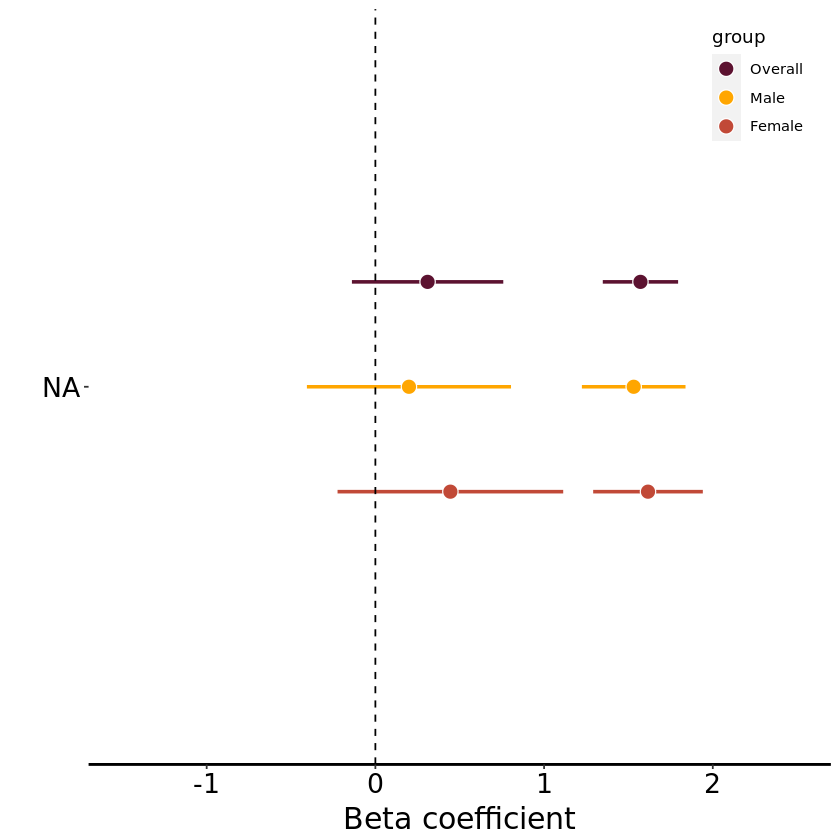

In [23]:
forestlm_bysex